In [1]:
import torch.nn as nn
layer = nn.Linear(64, 128)

print(layer.weight.min(), layer.weight.max())

tensor(-0.1250, grad_fn=<MinBackward1>) tensor(0.1250, grad_fn=<MaxBackward1>)


- A layer weights are initialized to small values
- Keeping both the input data and layer weights small ensures stable outputs

In [2]:
layer = nn.Linear(64, 128)
nn.init.uniform_(layer.weight)

print(layer.weight.min(), layer.weight.max())

tensor(0.0002, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)


**Transfer Learning**: Reusing a model trained on a first task for a second similar task

In [3]:
import torch

layer = nn.Linear(64, 128)

torch.save(layer, 'layer.pth')
new_layer = torch.load('layer.pth', weights_only=False)

**Fine-tuning**: A type of transfer learning

- Smaller learning rate
- Train part of the network (we freeze some of them)
- Rule of thumb: freeze early layers of network and fine-tune layers closer to output layer

In [4]:
import torch.nn as nn

model = nn.Sequential(nn.Linear(64, 128), 
                      nn.Linear(128, 256))

for name, param in model.named_parameters():
    if name == '0.weight':        
        param.requires_grad = False

In [5]:
# training ver 1

for name, param in model.named_parameters():
  
    # Check for first layer's weight
    if name == '0.weight':
   
        # Freeze this weight
        param.requires_grad = False
        
    # Check for second layer's weight
    if name == '1.weight':
      
        # Freeze this weight
        param.requires_grad = False

In [6]:
# training ver 2

layer0 = nn.Linear(16, 32)
layer1 = nn.Linear(32, 64)

# Use uniform initialization for layer0 and layer1 weights
nn.init.uniform_(layer0.weight)
nn.init.uniform_(layer1.weight)

model = nn.Sequential(layer0, layer1)

## Evaluating model performance 

A dataset is typically split into three subsets:

| Data Role   | Percent of Data | Purpose                              |
|-------------|-----------------|--------------------------------------|
| Training    | 80–90%          | Adjusts model parameters             |
| Validation  | 10–20%          | Tunes hyperparameters                |
| Test        | 5–10%           | Evaluates final model performance    |

Track loss and accuracy during training and validation

#### Calculating Training Loss

For each epoch:
- Sum the loss across all batches in the dataloader.
- Compute the mean training loss at the endof the epoch.

In [ ]:
training_loss = 0.0

for inputs, labels in trainloader:
    # Run the forward pass    
    outputs = model(inputs)
    
    # Compute the loss    
    loss = criterion(outputs, labels)
    
    # Backpropagation    
    loss.backward()  # Compute gradients
    optimizer.step() # Update weights
    optimizer.zero_grad() # Reset gradients
    
    # Calculate and sum the loss    
    training_loss += loss.item()
    epoch_loss = training_loss / len(trainloader)

In [ ]:
validation_loss = 0.0
model.eval() # Put model in evaluation mode

with torch.no_grad(): # Disable gradients for efficiency
    for inputs, labels in validationloader:
    # Run the forward pass     
    outputs = model(inputs)
    # Calculate the loss      
    loss = criterion(outputs, labels)     
    validation_loss += loss.item()
    
epoch_loss = validation_loss / len(validationloader) # Compute mean loss
model.train() # Switch back to training mode


### Calculating accuracy with torchmetrics

In [ ]:
import torchmetrics

# Create accuracy metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)
for features, labels in dataloader:    
    outputs = model(features)  # Forward pass
    # Compute batch accuracy (keeping argmax for one-hot labels)    
    metric.update(outputs, labels.argmax(dim=-1))

# Compute accuracy over the whole epoch
accuracy = metric.compute()
    
# Reset metric for the next epoch
metric.reset()

In [ ]:
# training ver 3

# Set the model to evaluation mode
model.eval()
validation_loss = 0.0

with torch.no_grad():
  for features, labels in validationloader:
      outputs = model(features)
      loss = criterion(outputs, labels)
      # Sum the current loss to the validation_loss variable
      validation_loss += loss.item()
      
# Calculate the mean loss value
validation_loss_epoch = validation_loss / len(validationloader)
print(validation_loss_epoch)

# Set the model back to training mode
model.train()

In [ ]:
# training ver 4

# Create accuracy metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)
for features, labels in dataloader:
    outputs = model(features)
    
    # Calculate accuracy over the batch
    metric.update(outputs, labels.argmax(dim=-1))
    
# Calculate accuracy over the whole epoch
accuracy = metric.compute()
print(f"Accuracy on all data: {accuracy}")

# Reset metric for the next epoch
metric.reset()
plot_errors(model, dataloader)

## Face Mask Dataset

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
import torchmetrics
import pickle

# Load dataset
with open("masks_dataset.pickle", "rb") as f:
    data = pickle.load(f)

features, labels = data  # e.g., (N, 3, 64, 64), (N,)
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Dataset & split
dataset = TensorDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model
model = nn.Sequential(
    nn.Linear(3072, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
)

# Freeze the first two layers (if needed)
for name, param in model.named_parameters():
    if name in ['0.weight', '2.weight']:
        param.requires_grad = False

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.view(batch_features.size(0), -1)  # flatten
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_features, val_labels in val_loader:
            val_features = val_features.view(val_features.size(0), -1)
            val_outputs = model(val_features)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

# Accuracy (final)
model.eval()
with torch.no_grad():
    for features, labels in val_loader:
        features = features.view(features.size(0), -1)
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)
        metric.update(preds, labels)

print(f"Final Accuracy: {metric.compute():.4f}")
metric.reset()

Epoch 1, Training Loss: 1.1085
Epoch 1, Validation Loss: 1.0973
Epoch 2, Training Loss: 1.0911
Epoch 2, Validation Loss: 1.0852
Epoch 3, Training Loss: 1.0762
Epoch 3, Validation Loss: 1.0742
Epoch 4, Training Loss: 1.0620
Epoch 4, Validation Loss: 1.0644
Epoch 5, Training Loss: 1.0500
Epoch 5, Validation Loss: 1.0557
Final Accuracy: 0.5211


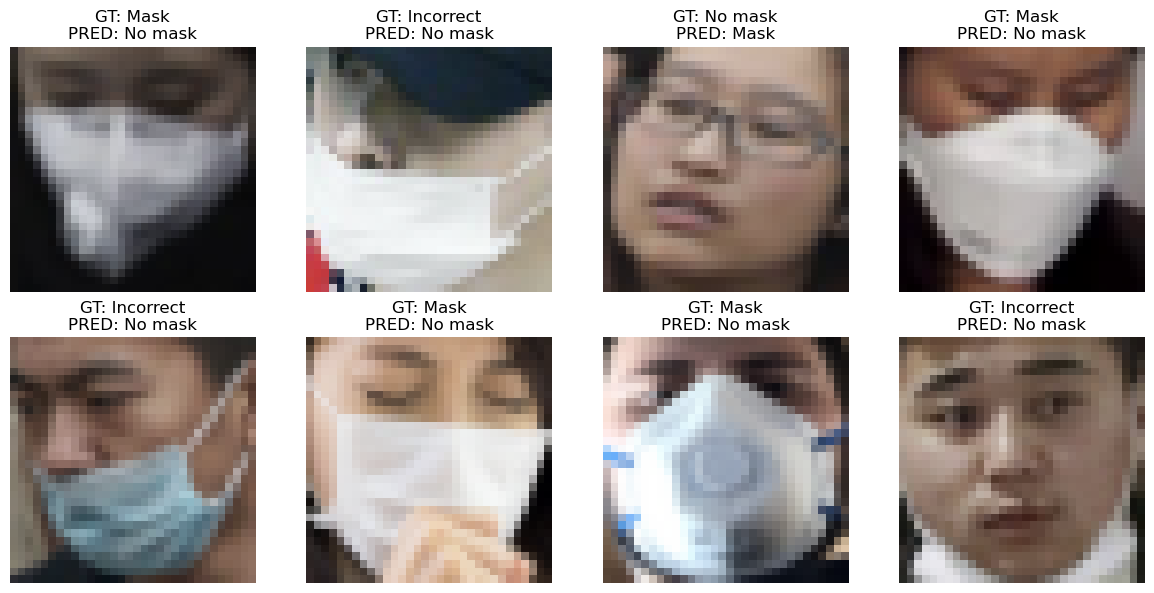

In [20]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['No mask', 'Mask', 'Incorrect']  # Adjust this if needed

def plot_errors(model, dataloader, num_images=8):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for features, labels in dataloader:
            # Flatten for model input
            flat_features = features.view(features.size(0), -1)
            outputs = model(flat_features)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((features[i], labels[i], preds[i]))
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    if len(misclassified) == 0:
        print("No misclassified samples found.")
        return

    plt.figure(figsize=(12, 6))
    for idx, (img_tensor, true_label, pred_label) in enumerate(misclassified):
        plt.subplot(2, num_images // 2, idx + 1)

        # Fix shape if needed
        if img_tensor.ndim == 3:
            if img_tensor.shape[0] == 3:
                # Shape is [3, H, W], convert to [H, W, 3]
                img = img_tensor.permute(1, 2, 0).numpy()
            elif img_tensor.shape[2] == 3:
                # Already [H, W, 3]
                img = img_tensor.numpy()
            else:
                raise ValueError(f"Cannot handle image shape: {img_tensor.shape}")
        else:
            raise ValueError(f"Image is not 3D: {img_tensor.shape}")

        # Clip values to [0, 1] for display
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"GT: {class_names[true_label]}\nPRED: {class_names[pred_label]}")
    plt.tight_layout()
    plt.show()

plot_errors(model, dataloader)

### Fighting Overfitting

**Overfitting**: the model does not generalize to unseen data
- Model memorizes training data
- Performs well on training data but poorly on validation data

Possible causes:
| Problem                    | Solution                              |
|---------------------------|----------------------------------------|
| Dataset is not large enough | Get more data / use data augmentation |
| Model has too much capacity | Reduce model size / add dropout       |
| Weights are too large      | Weight decay                          |

Strategies:
- Reducing model size or adding dropout layer
- Using weight decay to force parameters to remain small
- Obtaining new data or augmenting data

In [22]:
model = nn.Sequential(nn.Linear(8, 4),                      
                      nn.ReLU(),                      
                      nn.Dropout(p=0.5))

features = torch.randn((1, 8))
print(model(features))

tensor([[0.0000, 0.0000, 3.2499, 0.0000]], grad_fn=<MulBackward0>)


- Dropout is added **after** the activation function
- Behaves differently in training vs. evaluation - use **model.train()** for training and **model.eval()** to disable dropout during evaluation

In [24]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

- Controlled by the **weight_decay** parameter in the optimizer, typically set to a small value(e.g., 0.0001)
- **Weight decay** encourages smaller weights by adding a penalty during optimization
- Helps reduce overfitting, keeping weights smaller and improving generalization

In [25]:
# training ver 5

model = nn.Sequential(
    nn.Linear(8, 6),
    nn.Linear(6, 4),
    nn.Dropout(p=0.5))

model.train()
output_train = model(features)

# Forward pass in evaluation mode (Dropout disabled)
model.eval()
output_eval = model(features)

# Print results
print("Output in train mode:", output_train)
print("Output in eval mode:", output_eval)

Output in train mode: tensor([[-0.9689, -0.0000,  0.5943, -0.0000]], grad_fn=<MulBackward0>)
Output in eval mode: tensor([[-0.4845, -0.4652,  0.2971, -0.0014]], grad_fn=<AddmmBackward0>)


### Improving Model Performance

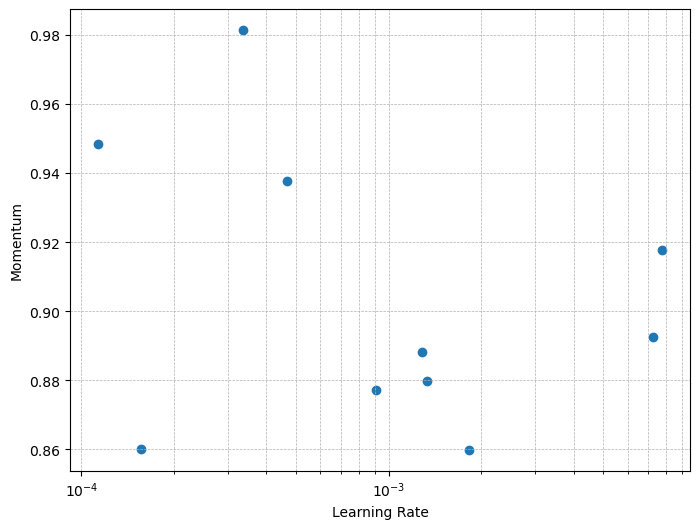

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hyperparameter_search(values):
    lrs, momentums = zip(*values)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(lrs, momentums)
    plt.xscale('log')
    plt.xlabel("Learning Rate")
    plt.ylabel("Momentum")
    plt.grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

# Generate 10 random hyperparameter combinations
values = []
for idx in range(10):
    # Randomly sample a learning rate factor between 2 and 4
    factor = np.random.uniform(2, 4)
    lr = 10 ** -factor

    # Randomly select a momentum between 0.85 and 0.99
    momentum = np.random.uniform(0.85, 0.99)

    values.append((lr, momentum))

# Plot the results
plot_hyperparameter_search(values)
